In [1]:
import pandas as pd 
import numpy as np
import sklearn as sk
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime as dt

In [3]:
appl_df = pd.read_csv(r'AAPL.csv')
appl_df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-04-23,204.429993,207.750000,203.899994,207.479996,204.799362,23323000
1,2019-04-24,207.360001,208.479996,207.050003,207.160004,204.483505,17540600
2,2019-04-25,206.830002,207.759995,205.119995,205.279999,202.627808,18543200
3,2019-04-26,204.899994,205.000000,202.119995,204.300003,201.660461,18649100
4,2019-04-29,204.399994,205.970001,203.860001,204.610001,201.966461,22204700
5,2019-04-30,203.059998,203.399994,199.110001,200.669998,198.077362,46534900
6,2019-05-01,209.880005,215.309998,209.229996,210.520004,207.800110,64827300
7,2019-05-02,209.839996,212.649994,208.130005,209.149994,206.447800,31996300
8,2019-05-03,210.889999,211.839996,210.229996,211.750000,209.014221,20892400
9,2019-05-06,204.289993,208.839996,203.500000,208.479996,205.786469,32443100


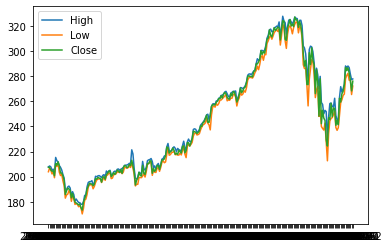

In [4]:
plt.plot(appl_df.Date, appl_df['High'], label = 'High')
plt.plot(appl_df.Date, appl_df['Low'], label = 'Low')
plt.plot(appl_df.Date, appl_df['Close'], label = 'Close')
plt.legend()
plt.show()

In [5]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

Using TensorFlow backend.


In [6]:
'''
def normalize(df, name):
    df[name] = (df['Open']/df[name]) - 1
'''

"\ndef normalize(df, name):\n    df[name] = (df['Open']/df[name]) - 1\n"

In [7]:
appl_df_columns_need = appl_df
appl_df_columns_need.drop(['Date'], axis = 1, inplace = True)
appl_df_columns_need.head()

,Open,High,Low,Close,Adj Close,Volume
0,204.429993,207.750000,203.899994,207.479996,204.799362,23323000
1,207.360001,208.479996,207.050003,207.160004,204.483505,17540600
2,206.830002,207.759995,205.119995,205.279999,202.627808,18543200
3,204.899994,205.000000,202.119995,204.300003,201.660461,18649100
4,204.399994,205.970001,203.860001,204.610001,201.966461,22204700


In [8]:
from collections.abc import Sequence
from sklearn import preprocessing

def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

In [9]:
# Normalize Cols
for col in appl_df.columns:
    encode_numeric_zscore(appl_df_columns_need, col)
    appl_df_columns_need[col]

appl_df_columns_need.head()

,Open,High,Low,Close,Adj Close,Volume
0,-0.888715,-0.866985,-0.854151,-0.822428,-0.849776,-0.575934
1,-0.819758,-0.850101,-0.779103,-0.829897,-0.857056,-0.909356
2,-0.832231,-0.866754,-0.825085,-0.873780,-0.899829,-0.851544
3,-0.877654,-0.930590,-0.896559,-0.896655,-0.922125,-0.845438
4,-0.889421,-0.908155,-0.855104,-0.889419,-0.915072,-0.640417


## using Open, High, Low, Adj Close and Volume to predict Close

In [14]:

x, y = to_xy(appl_df_columns_need, 'Close')

In [15]:
x.shape

(253, 5)

In [16]:
y.shape

(253,)

In [36]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [37]:
print('x train shape: ', x_train.shape)
print('y train shape: ', y_train.shape)
print('------------------------')
print('x test shape: ', x_test.shape)
print('y test shape: ', y_test.shape)
print(x_train.shape[1:])

x train shape:  (189, 5)
y train shape:  (189,)
------------------------
x test shape:  (64, 5)
y test shape:  (64,)
(5,)


In [29]:
# x_train = np.reshape(x_train,(1,x_train.shape[0],x_train.shape[1]))
# x_test = np.reshape(x_test,(1,x_test.shape[0],x_test.shape[1]))

In [30]:
model = Sequential()

model.add(LSTM(10, input_shape = (189,5), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [31]:
model.fit(x_train, y_train, batch_size=512, nb_epoch = 1, validation_split = .05)

ValueError: Input arrays should have the same number of samples as target arrays. Found 1 input samples and 189 target samples.

In [38]:
model2 = Sequential()
model2.add(Dense(10,input_shape=(5,),activation='relu'))
model2.add(Dense(1))

In [39]:
model2.compile(loss='mean_squared_error',optimizer='adam')

In [40]:
pred = model2.predict(x_test)

In [41]:
y_true = 

array([[ 0.5801761 ],
       [ 0.14864561],
       [-0.29688358],
       [ 0.61891216],
       [-0.21977128],
       [ 0.7349161 ],
       [ 0.6280987 ],
       [ 0.62659967],
       [-0.34444737],
       [-0.5496607 ],
       [ 0.44886518],
       [ 0.599409  ],
       [ 0.72626674],
       [ 0.5879981 ],
       [ 0.06431562],
       [-0.27465326],
       [ 0.6280117 ],
       [-0.4367137 ],
       [-0.31993395],
       [-0.62308407],
       [ 0.50148654],
       [-0.42651868],
       [ 0.03840536],
       [ 0.17098618],
       [-0.5430733 ],
       [-0.1823769 ],
       [ 0.3174674 ],
       [ 0.6046835 ],
       [-0.23704655],
       [ 0.45508346],
       [ 0.46778724],
       [-0.2601053 ],
       [ 0.16031733],
       [ 0.42085838],
       [ 0.5026145 ],
       [-0.63967526],
       [-0.07543296],
       [-0.488764  ],
       [-0.44969928],
       [ 0.02245189],
       [ 0.8866024 ],
       [ 0.32864147],
       [ 0.13526934],
       [ 0.10937229],
       [-0.48714054],
       [-0

In [42]:
from sklearn import metrics
mse = metrics.mean_squared_error(pred,y_test)

In [43]:
mse

0.47653687

In [44]:
print(np.sqrt(mse))

0.6903165
